# Social Network Analysis - Final Project
### Influence spread and virality II

# TODO
- Normalize evaluation functions (X)
- Implement different cooling schedule 
- Tune SA hyperparameters
- (Optional: implement another algorithm, e.g. Evolutionary Strategy)


## Preliminaries

In [47]:
import numpy as np
import pandas as pd
import time
import networkx as nx
from functools import reduce
import operator
from random import choice, randint
import functools
import os
import heapq 
import copy
import matplotlib.pyplot as plt

## Load data

In [2]:
def edgelist_csv_to_graph(filename="./Data/5new_sites_edges.csv"):
    '''
    Converts a .csv file in edgelist format to a networkX graph. 
    :param filename: relative path to the csv file
    :return G: Returns a networkx undirected graph object
    '''

    df = pd.read_csv(filename, sep=";")
    G = nx.from_pandas_edgelist(df, source="Source", target="Target")
    del df
    return G

In [3]:
G = edgelist_csv_to_graph()

In [4]:
len(G.nodes)

27599

In [5]:
len(G.edges)

206222

## Outbreak simulation

In [6]:
def simulate_outbreak(G, init_nodes=[], p=0.05, n_runs=10):
    '''
    Simulates an outbreak, either from a random node or a prespecified set of nodes.
    :param G: networkx graph object to use as network
    :param initial_infected nodes: list of nodes to start the outbreak from, if empty choose random node
    :param n_runs: how many outbreaks to simulate
    :return all_runs_list: returns a list of lists, where each 
                            inner list is a list of infected nodes resulting from that run
    '''
    
    # List with all runs output
    all_runs_list = []
    # Run the algorithm 'n_runs' times
    for run in range(n_runs):
        np.random.seed(run)
        initial_infected_nodes = []
        # Using a fixed p or sampling from a 20-60 distribution
        if p==False:
            prob = np.random.uniform(20,60,1)[0]/100
        else:
            prob = p

        if init_nodes==[]:
            initial_infected_nodes = [choice(list(G.nodes()))]
            
        else:
            initial_infected_nodes = init_nodes

        # Random seed equals to run so we always can recover the same output
        # np.random.seed(run)
        # Nodes that are infecting other nodes in this time step
        transmissible_nodes = initial_infected_nodes
        # Nodes that become infected in this time step - at start, by default, none
        just_infected = []
        # History of all nodes that become infected - at the start just the the initial nodes
        all_infected = [initial_infected_nodes]
        # The algorithm runs when there is at least one trasmissible node
        while transmissible_nodes:
            # For each node recently infected we are going to check its neighbors and infect new nodes with probability p
            for n in transmissible_nodes:
                current_neighbors = list(G.neighbors(n))
                infection = np.random.uniform(0,1,len(current_neighbors)) < prob
                just_infected += list(np.extract(infection, current_neighbors))
            # Now the recent infected become the trasmissible nodes (only if they were not infected before)
            transmissible_nodes = list(set(just_infected) - set(reduce(operator.concat, all_infected)))
            # And they are added to the list with the history of all nodes infected
            all_infected.extend([transmissible_nodes])
        # Removing the last blank element (the last element is always a blank list)
        all_infected = all_infected[:-1]
        # Appending t the list with the output from all runs
        all_runs_list.append(all_infected)

    return all_runs_list


In [7]:
def simulate_outbreak_inverted_index(G, init_nodes=[], p=0.05, n_runs=10):
    '''
    Simulates an outbreak, either from a random node or a prespecified set of nodes.
    :param G: networkx graph object to use as network
    :param initial_infected nodes: list of nodes to start the outbreak from, if empty choose random node
    :param n_runs: how many outbreaks to simulate
    :return all_runs_list: returns a list of lists, where each 
                            inner list is a list of infected nodes resulting from that run
    '''
    
    # List with all runs output
    all_runs_dicts = []
    # Run the algorithm 'n_runs' times
    for run in range(n_runs):
        outbreak_dict = dict()
        initial_infected_nodes = []
        # Using a fixed p or sampling from a 20-60 distribution
        if p==False:
            prob = np.random.uniform(20,60,1)[0]/100
        else:
            prob = p

        if init_nodes==[]:
            initial_infected_nodes = [choice(list(G.nodes()))]
            
        else:
            initial_infected_nodes = init_nodes

        # Random seed equals to run so we always can recover the same output
        # np.random.seed(run)
        # Nodes that are infecting other nodes in this time step
        transmissible_nodes = initial_infected_nodes
        # Nodes that become infected in this time step - at start, by default, none
        just_infected = []
        # History of all nodes that become infected - at the start just the the initial nodes
        [outbreak_dict.update({node:0}) for node in initial_infected_nodes]
        # The algorithm runs when there is at least one trasmissible node
        i = 1
        all_infected = [initial_infected_nodes]
        while transmissible_nodes:
            # For each node recently infected we are going to check its neighbors and infect new nodes with probability p
            for n in transmissible_nodes:
                current_neighbors = list(G.neighbors(n))
                infection = np.random.uniform(0,1,len(current_neighbors)) < prob
                just_infected += list(np.extract(infection, current_neighbors))
            # Now the recent infected become the trasmissible nodes (only if they were not infected before)
            transmissible_nodes = list(set(just_infected) - set(reduce(operator.concat, all_infected)))
            # And they are added to the list with the history of all nodes infected
#             all_infected.extend([transmissible_nodes])
            [outbreak_dict.update({node:i}) for node in transmissible_nodes]
            all_infected.extend([transmissible_nodes])
            i += 1
        # Removing the last blank element (the last element is always a blank list)
        all_infected = all_infected[:-1]
        # Appending t the list with the output from all runs
        output = (outbreak_dict, all_infected)
        all_runs_dicts.append(output)

    return all_runs_dicts

## Evaluation functions

In [8]:
#Fraction of information cascades and contamination events detected by the selected nodes
def detection_likelihood(outbreak_simulations, placement, inverse=True):
    '''
    For a given run or multiple runs, calculate the placement score with detection likelihood as objective
    :param outbreak_simulations: outbreak simulation data generated by simulate_outbreak
    :param placement: solution set of nodes to calculate score for
    :param inverse: if inverse is set to True, return 1 - detection likelihood score, such that a lower score is a better score
    :return: Returns the average detection likelihood score (between 0 and 1) over all runs
    '''
    detection_count = 0
    # For each run we need to compute the detection likelihood
    
    for run in outbreak_simulations:
        # If any node in the placement got infeceted then we detected the outbreak
#         if list(set(placement) & set(reduce(operator.concat, run))):
#             detection_count += 1
        for node in placement:
            if node in run[0]:
                detection_count +=1
                break
        
    # We need the detection likelihood thus the number of detection divded by the total number of simulations
    dl = (detection_count/len(outbreak_simulations))
    
    if inverse:
        return 1-dl
    
    else:
        return dl

def detection_time(outbreak_simulations, placement):
    '''
    For a given run or multiple runs, calculate the placement score with detection time as objective
    :param outbreak_simulations: outbreak simulation data generated by simulate_outbreak
    :param placement: solution set of nodes to calculate score for
    :return: Returns the average detection time score over all runs
    '''
          
    # Output is a list with the time step in which the outbreak was detected for each run
    output = []
    # Creating a set for the placement
    # For each run we need to compute the detection time
    for run in outbreak_simulations:
        detected = False
        dt = {}
        for node in placement:
            if node in run[0]:
                detected = True 
                dt.update({node:run[0][node]})        
        if detected:
            
            output.append(dt[min(dt.keys(), key=(lambda k: dt[k]))]/len(run[1]))
        else:
#             max_penalty = 0
#             for iteration in run[1]:
#                 max_penalty+=len(iteration)
            output.append(1)
    return np.mean(output)

def population_affected(outbreak_simulations, placement):
    '''
    For a given run or multiple runs, calculate the placement score with population affected as objective
    :param outbreak_simulations: outbreak simulation data generated by simulate_outbreak
    :param placement: solution set of nodes to calculate score for
    :return: Returns the average population affected score over all runs
    '''
          
    # Output is a list with the population affected in each outbreak run
    output = []
    # Creating a set for the placement
#     set_placement = set(placement)
    # For each run we need to compute the population affected
    for run in outbreak_simulations:
        pa = 0
        # If any node in the placement got infeceted then we detected the outbreak and we need to check the population affected
        
        detected = False
        
        dt = -1
        min_dt = np.inf
        for node in placement:
            if node in run[0]:
                dt = run[0][node] 
                detected=True
                if dt < min_dt:
                    min_dt = dt
        pa = 0
        if detected:
            for i in range(0, min_dt):
                pa += len(run[1][i])
        else:
            for i in range(0, len(run[1])):
                pa += len(run[1][i])
        
        output.append(pa/len(run[0]))
    return np.mean(output)

## Naive greedy algorithm

In [200]:
def naive_greedy(outbreak_simulations, budget, eval_function, G, verbosity=0):
    '''
    Using a naive greedy strategy: find the best placement, given outbreak simulation data and an objective function, constrained to a budget.
    :param outbreak_simulations: outbreak simulation data generated by simulate_outbreak
    :param budget: The total cost of selecting nodes cannot exceed the budget
    :param eval_function: Which objective function to use to calculate placement score
    :param G: networkx graph object to use as network
    :return placement: Return best found solution set of nodes
    
    '''
    t_total = time.time()
    eval_function = functools.partial(eval_function, outbreak_simulations=outbreak_simulations)
    nodes = list(G.nodes())
    n_nodes = len(nodes)
    placement = []
#     total_gain = 0
    #Finding best placement
    for i in range(budget):
        t_iter = time.time()
        scores = []
        for n in nodes:
            placement.append(n)
            scores.append(eval_function(placement=placement))
            placement.remove(n)
        best_node = nodes[np.argmin(scores)]
        placement.append(best_node)
        nodes.remove(best_node)
        
        if verbosity >= 2:
            print("Finished iteration " + str(i+1) + " in " + str(time.time()-t_iter))
        
    if verbosity >= 1:
        print("Total time: " + str(time.time()-t_total))
    
    return placement, eval_function(placement=placement), fe_total

## CELF

1. Maintain priority queue (u, u.marginal_gain, u.iter)
2. If node chosen had its marginal_gain computer in the current iteration, then it must be the best node for the current iteration.

Handy link to understand min heap implementation: https://www.techbeamers.com/python-heapq/

In [10]:
def CELF(outbreak_simulations, budget, eval_function, G, verbosity = 2):
    '''
    Using the CELF algorithm: find the best placement, given outbreak simulation data and an objective function, constrained to a budget.
    :param outbreak_simulations: outbreak simulation data generated by simulate_outbreak
    :param budget: The total cost of selecting nodes cannot exceed the budget
    :param eval_function: Which objective function to use to calculate placement score
    :param G: networkx graph object to use as network
    :return placement: Return best found solution set of nodes
    '''
  
    t_total = time.time()
    fe_total = 0
    eval_function = functools.partial(eval_function, outbreak_simulations=outbreak_simulations)

    nodes = list(G.nodes())

    # Construct heap for first iteration of format (marginal gain, node)
    node_heap = []
    placement = []
    scores = []
    total_penalty = eval_function(placement = [])
    fe_total += 1
    t_iter = time.time()
    for node in nodes:
        penalty = eval_function(placement = [node])
        marginal_gain = total_penalty - penalty
        # heapq implements a min heap, which keeps the smallest element at the top of the heap
        # but we need it the other way around, therefore we multiply the marginal_gain by -1
        heapq.heappush(node_heap, (-marginal_gain, node))
    
    fe_total += len(nodes)
    
    # Remove best node from heap and add to solution set
    best_gain, best_node = heapq.heappop(node_heap)
    total_penalty = total_penalty + best_gain
    placement.append(best_node)
    
    if verbosity >= 2:
        print("Finished iteration " + str(len(placement)) + " in " + str(time.time()-t_iter))

    
    while len(placement) < budget:
        t_iter = time.time()
        top_node_unchanged = False

        while not top_node_unchanged:
            _, current_node = heapq.heappop(node_heap)
            placement.append(current_node)
            current_penalty = eval_function(placement=placement)
            fe_total += 1
            placement.remove(current_node)
            marginal_gain = total_penalty - current_penalty

            # check if the previous top node stayed on the top after pushing
            # the marginal gain to the heap
            heapq.heappush(node_heap, (-marginal_gain, current_node))
            _, top_node = node_heap[0]
            
            if top_node == current_node:
                top_node_unchanged = True
            
        marginal_gain, current_node = heapq.heappop(node_heap)
        # marginal gain is stored as negative, so use plus instead of minus
        total_penalty = total_penalty + marginal_gain
        
        placement.append(current_node)
        
        if verbosity >= 2:
            print("Finished iteration " + str(len(placement)) + " in " + str(time.time()-t_iter))
            print(eval_function(placement = placement))
    
    if verbosity >= 1:
        print("Total time: " + str(time.time()-t_total))
        print("Total function evaluations: " + str(fe_total))

    return placement, eval_function(placement = placement), fe_total

## Simulated Annealing

In [110]:
def generate_initial_solution(nodes, budget):
    '''
    Creates a random solution of length budget
    '''
    placement = []
    for i in range(0, budget):
        node = nodes[randint(0,len(nodes)-1)]
#         nodes.remove(node)
        placement.append(node)
    return placement

def perturb(placement, nodes):
    '''
    Creates a neighbor solution by 
    randomly replacing a node from placement by a node from nodes
    '''
    to_replace = randint(0, len(placement)-1)
    replace_with = randint(0,len(nodes)-1)
    placement[to_replace] = nodes[replace_with]
    
    return placement

def SA(outbreak_simulations, budget, eval_function, G, t_start=10, t_end=0.0001, delta_t=0.0001, n_perturbations = 100, verbosity = 2):
    '''
    Simulated annealing algorithm to determine the nodes that minimize the total penalty of the eval_function.
    '''
    fe_total = 0
    fe_best = 0
    nodes = list(G.nodes())
    placement = generate_initial_solution(nodes, budget)
    placement_score = eval_function(outbreak_simulations, placement)
    best_placement = placement
    best_score = placement_score
#     history = [placement_score]
#     p_history = []
#     b_history = [placement_score]
    t = t_start
    while(t > t_end):
        init_time = time.time()
        for i in range(0, n_perturbations):
            new_placement = perturb(copy.deepcopy(placement), nodes)
            new_placement_score = eval_function(outbreak_simulations, new_placement)
            delta_f = new_placement_score - placement_score
            fe_total += 1
            if delta_f <= 0:
                placement = new_placement
                placement_score = new_placement_score
            else:
                probability = np.exp(-delta_f / t)
#                 p_history.append(probability)
#                 if (probability>0):
#                     print(probability)
                if np.random.uniform(0,1) < np.min([1.0, probability]):
                    placement = new_placement
                    placement_score = new_placement_score
             
            if(placement_score < best_score):
                best_placement = placement
                best_score = placement_score
                fe_best = fe_total
                
        t -= delta_t
#         history.append(placement_score)
#         b_history.append(best_score)

    return best_placement, best_score, fe_best
        

In [144]:
def SA_cauchy(outbreak_simulations, budget, eval_function, G, t_start=10, n_eval=100000, n_perturbations = 100, verbosity = 2):
    '''
    Simulated annealing algorithm to determine the nodes that minimize the total penalty of the eval_function.
    '''
    fe_total = 0
    fe_best = 0
    nodes = list(G.nodes())
    placement = generate_initial_solution(nodes, budget)
    placement_score = eval_function(outbreak_simulations, placement)
    best_placement = placement
    best_score = placement_score
    history = [placement_score]
    p_history = []
    b_history = [placement_score]
    t = t_start
    cur_iter=1
    while(cur_iter <= n_eval/n_perturbations):
        init_time = time.time()
        for i in range(0, n_perturbations):
            new_placement = perturb(copy.deepcopy(placement), nodes)
            new_placement_score = eval_function(outbreak_simulations, new_placement)
            delta_f = new_placement_score - placement_score
            fe_total += 1
            if delta_f <= 0:
                placement = new_placement
                placement_score = new_placement_score
            else:
                probability = np.exp(-delta_f / t)
#                 p_history.append(probability)
                if np.random.uniform(0,1) < np.min([1.0, probability]):
                    placement = new_placement
                    placement_score = new_placement_score
             
            if(placement_score < best_score):
                best_placement = placement
                best_score = placement_score
                fe_best = fe_total

                
        t = t_start / cur_iter
        cur_iter += 1
        
#         history.append(placement_score)
#         b_history.append(best_score)

    return best_placement, best_score, fe_best
        

In [145]:
def SA_geometric(outbreak_simulations, budget, eval_function, G, t_start=10, n_eval=100000, n_perturbations = 100, alpha = 0.95, verbosity = 2):
    '''
    Simulated annealing algorithm to determine the nodes that minimize the total penalty of the eval_function.
    '''
    fe_total = 0
    fe_best = 0
    nodes = list(G.nodes())
    placement = generate_initial_solution(nodes, budget)
    placement_score = eval_function(outbreak_simulations, placement)
    best_placement = placement
    best_score = placement_score
#     history = [placement_score]
#     p_history = []
#     b_history = [placement_score]
    t = t_start
    cur_iter=1
    while(cur_iter <= n_eval/n_perturbations):
        init_time = time.time()
        for i in range(0, n_perturbations):
            new_placement = perturb(copy.deepcopy(placement), nodes)
            new_placement_score = eval_function(outbreak_simulations, new_placement)
            delta_f = new_placement_score - placement_score
            fe_total += 1
            if delta_f <= 0:
                placement = new_placement
                placement_score = new_placement_score
            else:
                probability = np.exp(-delta_f / t)
#                 p_history.append(probability)
                if np.random.uniform(0,1) < np.min([1.0, probability]):
                    placement = new_placement
                    placement_score = new_placement_score
             
            if(placement_score < best_score):
                best_placement = placement
                best_score = placement_score
                fe_best = fe_total
        

        t = t_start * (alpha ** cur_iter)
        cur_iter += 1
        
#         history.append(placement_score)
#         b_history.append(best_score)

    return best_placement, best_score, fe_total

In [132]:
def SA_SASH(outbreak_simulations, budget, eval_function, G, t_start=0.1, t_end=0, delta_t=0.0001, n_perturbations = 100, verbosity = 2):
    '''
    Simulated annealing algorithm to determine the nodes that minimize the total penalty of the eval_function.
    '''
    
    init_time = time.time()
    nodes = list(G.nodes())
    scores = np.array([eval_function(outbreak_simulations, [node]) for node in nodes])
    placement = generate_initial_solution(nodes, budget)
    placement_score = eval_function(outbreak_simulations, placement)
    max_penalty = eval_function(outbreak_simulations, [])
    scores = scores - max_penalty
    best_placement = placement
    best_score = placement_score
    
    penalty_sum = np.sum(scores)
    p = [score / penalty_sum for score in scores]
    
    t = t_start
    print("Initialisation took " + str(time.time()-init_time))
    while(t > t_end):
        init_time = time.time()
        neighborhood = nodes_within_distance(placement, G, 2)
        for i in range(0, n_perturbations):
            new_placement = SASH(G, copy.deepcopy(nodes), scores, copy.deepcopy(placement), p, neighborhood)
            new_placement_score = eval_function(outbreak_simulations, new_placement)
            delta_f = new_placement_score - placement_score
            if delta_f <= 0:
                placement = new_placement
                placement_score = new_placement_score
            else:
                probability = np.exp(-delta_f / t)
#                 print("f: " + str(delta_f))
#                 print("p: "+ str(probability))
                if np.random.uniform(0,1) < np.min([1.0, probability]):
                    placement = new_placement
                    placement_score = new_placement_score
                    
            if(placement_score < best_score):
                best_placement = placement
                best_score = placement_score
        t -= delta_t
#         print("One temperature decrease iteration took: " + str(time.time()- init_time))
#         print("Current score: " + str(placement_score))
#         print("Current best: " + str(best_score))
    print("Best score: " + str(best_score))
    print("Final score: " + str(placement_score)) 
#         print(t)
    return best_placement, best_score
  

In [133]:
def nodes_within_distance(placement, G, distance):
    t_start = time.time()
    nodes_within_d = set()
    nodes = placement
    for d in range(0, distance):
        neighbors = set()
        for n in nodes:
            neighbors.update(list(G.neighbors(n)))
        nodes_within_d.update(neighbors)    
        nodes = neighbors    
    return nodes_within_d   

In [134]:
def SASH(G, nodes, scores, placement, p, neighborhood):
    t_start = time.time()
    
    n = len(placement)
    n_nodes = len(nodes)
      
    while True:
        r = randint(0, n-1)
        replacement = nodes[np.random.choice(n_nodes, p=p)]
        if(replacement not in neighborhood):
            if(placement[r] != replacement):
                placement[r] = replacement
                return placement


In [135]:
t_start = time.time()
SA_placement, SA_score = SA_SASH(outbreak_simulations, budget, detection_time, G, t_start = 0.01, t_end = 0.00001, delta_t = 0.0001)
print(SA_placement)
print(SA_score)
print(time.time()-t_start)

Initialisation took 1.1560304164886475
Best score: 0.8084790470399166
Final score: 0.8084790470399166
[7129, 23152, 19503, 14177, 10301]
0.8084790470399166
161.5653314590454


In [119]:
t_start = time.time()
SA_placement, SA_score, history, p_history, b_history = SA(outbreak_simulations, budget, detection_time, G, t_start = 0.01, t_end = 0.00001, delta_t = 0.00001)
print(SA_placement)
print(SA_score)
print(time.time()-t_start)

Best score: 0.7951521975608933
Final score: 0.7951521975608933
Total function evaluations: 100000
[2211, 3048, 3684, 1554, 5581]
0.7951521975608933
10.966214418411255


In [146]:
t_start = time.time()
SA_placement, SA_score, history, p_history, b_history = SA_cauchy(outbreak_simulations, budget, detection_time, G, t_start = 0.01, n_eval=100000)
print(SA_placement)
print(SA_score)
print(time.time()-t_start)

Best score: 0.7905607212433299
Final score: 0.7905607212433299
Total function evaluations: 100000
[4327, 8978, 6990, 1228, 22263]
0.7905607212433299
11.840978622436523


In [196]:
t_start = time.time()
SA_placement, SA_score, history, p_history, b_history = SA_cauchy(outbreak_simulations, budget, detection_time, G, t_start = 0.01, n_eval=100000)
print(SA_placement)
print(SA_score)
print(time.time()-t_start)

Best score: 0.7904830814917772
Final score: 0.7904830814917772
Total function evaluations: 100000
[14712, 4327, 8978, 21432, 19806]
0.7904830814917772
11.700236320495605


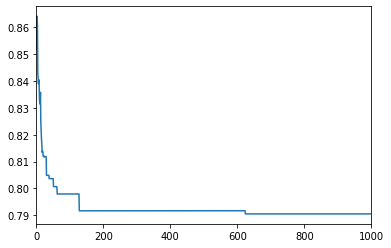

In [197]:
pd.Series(history).plot()
plt.show()

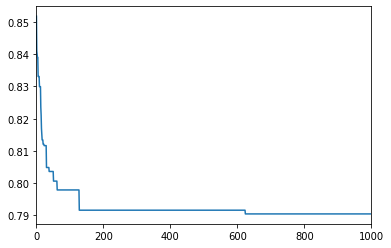

In [198]:
pd.Series(b_history).plot()
plt.show()

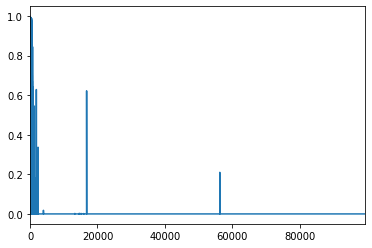

In [199]:
pd.Series(p_history).plot()
plt.show()

In [22]:
# Generating outbreaks scenarios and other parameters
n_scenarios = 100
outbreak_simulations = simulate_outbreak_inverted_index(G=G, n_runs=n_scenarios, p=0.05)
budget = 5

In [185]:
# Naive Algorithm
print("NAIVE")
naive_placement, naive_score = naive_greedy(outbreak_simulations, budget=budget, eval_function = detection_time, G=G)
print(naive_placement)
print(naive_score)
# CELF
print("CELF")
i_time = time.time()
celf_placement, celf_score = CELF(outbreak_simulations, budget=budget, eval_function = detection_time, G=G)
print(celf_placement)
print(celf_score)

NAIVE
Finished iteration 1 in 1.3120336532592773
Finished iteration 2 in 1.890211820602417
Finished iteration 3 in 2.0307772159576416
Finished iteration 4 in 2.296335458755493
Finished iteration 5 in 2.45255446434021
Total time: 9.981912612915039
[8978, 4327, 14712, 1228, 3]
0.7901259386346342
CELF
Finished iteration 1 in 1.249675989151001
Finished iteration 2 in 1.140408992767334
0.8209178641004727
Finished iteration 3 in 0.07805633544921875
0.8104830814917772
Finished iteration 4 in 0.0
0.8001259386346342
Finished iteration 5 in 0.015620708465576172
0.7901259386346342
Total time: 2.48376202583313
Total function evaluations: 44753
[8978, 4327, 14712, 1228, 3]
0.7901259386346342


In [87]:
detection_time(outbreak_simulations, [])

1.0

In [79]:
population_affected(outbreak_simulations, [])

1.0

In [83]:
detection_likelihood(outbreak_simulations, [])

1.0